In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import splitfolders
import tensorflow.compat.v1 as tf1
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam as Adam
from tensorflow.keras.optimizers import SGD as SGD
from tensorflow.keras.optimizers import RMSprop as RMSprop
from tensorflow.keras.optimizers import Adagrad as Adagrad
from tensorflow.keras.optimizers import Adadelta as Adadelta
from tensorflow.keras.optimizers import Adamax as Adamax
from tensorflow.keras.optimizers import Nadam as Nadam
import shutil
import tensorflow_ranking as tfr
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

2022-08-14 01:42:37.190016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/lunet/conm/.conda/envs/stenosispyv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(device_lib.list_local_devices())
# check available GPU with tensorflow
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15327238976176206147
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10452015552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15860824638805434929
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


2022-08-14 01:42:47.795445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-14 01:42:47.795748: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 01:42:47.796375: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-14 01:42:47.890447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 01:42:47.891217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [3]:
train_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/train/stenosis'

test_path = '/home/lunet/conm/Desktop/Stenosis-Project/test_images'

val_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/val/stenosis'

In [4]:
# Prevent Python from running out of memory during model training
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)
K.set_session(sess)

2022-08-14 01:42:48.443150: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 01:42:48.443515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 01:42:48.444942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-14 01:42:48.445041: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-14 01:42:48.445107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 01:42:48.445162: I tensorflow/stream_executor/plat

In [5]:
# Read train_labels.csv
train_labels_csv = pd.read_csv('train_labels.csv')
train_labels_csv

,filename,width,height,class,xmin,ymin,xmax,ymax
0,14_024_2_0042.bmp,800,800,Stenosis,235,156,282,192
1,14_031_4_0031.bmp,800,800,Stenosis,419,319,446,349
2,14_046_5_0066.bmp,1000,1000,Stenosis,679,307,699,336
3,14_010_6_0035.bmp,512,512,Stenosis,94,244,126,286
4,14_014_1_0015.bmp,512,512,Stenosis,163,118,203,151
...,...,...,...,...,...,...,...,...
6737,14_066_7_0059.bmp,800,800,Stenosis,229,100,254,160
6738,14_088_8_0077.bmp,800,800,Stenosis,512,319,576,347
6739,14_095_7_0045.bmp,800,800,Stenosis,199,218,229,273
6740,14_051_6_0026.bmp,512,512,Stenosis,258,181,277,216


In [6]:
test_labels_csv = pd.read_csv('test_labels.csv')
test_labels_csv

,filename,width,height,class,xmin,ymin,xmax,ymax
0,14_029_7_0058.bmp,800,800,Stenosis,288,369,328,398
1,14_024_1_0052.bmp,800,800,Stenosis,166,160,202,202
2,14_095_2_0075.bmp,800,800,Stenosis,461,337,492,379
3,14_075_6_0035.bmp,512,512,Stenosis,128,136,189,158
4,14_081_7_0026.bmp,800,800,Stenosis,323,177,351,230
...,...,...,...,...,...,...,...,...
828,14_066_8_0028.bmp,800,800,Stenosis,125,175,161,216
829,14_048_1_0057.bmp,1000,1000,Stenosis,264,427,306,458
830,14_051_2_0051.bmp,512,512,Stenosis,82,297,110,344
831,14_051_2_0025.bmp,512,512,Stenosis,77,248,102,284


In [7]:
val_labels_csv = pd.read_csv('val_labels.csv')
val_labels_csv

,filename,width,height,class,xmin,ymin,xmax,ymax
0,14_029_5_0059.bmp,800,800,Stenosis,192,423,237,459
1,14_006_1_0138.bmp,800,800,Stenosis,471,438,560,575
2,14_087_1_0090.bmp,800,800,Stenosis,256,250,335,300
3,14_021_37_0019.bmp,512,512,Stenosis,187,408,239,431
4,14_057_3_0061.bmp,1000,1000,Stenosis,389,117,443,174
...,...,...,...,...,...,...,...,...
745,14_029_1_0068.bmp,800,800,Stenosis,297,265,356,310
746,14_095_2_0035.bmp,800,800,Stenosis,435,375,473,416
747,14_095_1_0080.bmp,800,800,Stenosis,501,498,546,529
748,14_048_3_0074.bmp,1000,1000,Stenosis,458,181,479,199


In [8]:
train_images = []
train_targets = []

In [9]:
val_images = []
val_targets = []

In [10]:
test_images = []
test_targets = []

In [11]:
for index, row in train_labels_csv.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(train_path,filename))
    pic = cv2.resize(pic, (350, 350))
    # pic_arr = keras.preprocessing.image.img_to_array(pic)

    train_images.append(pic)
    train_targets.append((xmin, ymin, xmax, ymax))

In [12]:
for index, row in val_labels_csv.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(val_path,filename))
    pic = cv2.resize(pic, (350, 350))
    # pic_arr = keras.preprocessing.image.img_to_array(pic)

    val_images.append(pic)
    val_targets.append((xmin, ymin, xmax, ymax))

In [13]:
for index, row in test_labels_csv.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(test_path,filename))
    pic = cv2.resize(pic, (350, 350))
    # pic_arr = keras.preprocessing.image.img_to_array(pic)

    test_images.append(pic)
    test_targets.append((xmin, ymin, xmax, ymax))

In [14]:
train_images = np.asarray(train_images).astype('float32')
train_targets = np.asarray(train_targets).astype('float32')

In [15]:
val_images = np.asarray(val_images).astype('float32')
val_targets = np.asarray(val_targets).astype('float32')

In [16]:
test_images = np.asarray(test_images).astype('float32')
test_targets = np.asarray(test_targets).astype('float32')

In [17]:
test_images.shape

(833, 350, 350, 3)

In [18]:
val_images.shape

(750, 350, 350, 3)

In [19]:
train_images.shape

(6742, 350, 350, 3)

In [20]:
# Normalize targets
train_targets /= 256
val_targets /= 256

# Normalize images
train_images /= 255
val_images /= 255

# Normalize test images
test_images /= 255
test_targets /= 256

In [21]:
dataGenerator = ImageDataGenerator(rotation_range=0, 
                                   zoom_range=0, 
                                   width_shift_range=0, 
                                   height_shift_range=0, 
                                   horizontal_flip=True,
                                   vertical_flip=True,)

In [22]:
# Create a new model for object detection and transfer learning
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(350, 350, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
initializer = tf.keras.initializers.HeUniform()
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.5))

model.add(Dense(4))
# Add custom metric for mean average precision to model.compile
# add learning rate

model.compile(loss='mse', optimizer='adam', metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])
# model.compile(loss='mse', optimizer='adam', metrics=['mae'])


2022-08-14 01:45:05.518390: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 01:45:05.735911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 01:45:05.737386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-14 01:45:06.377753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-14 01:45:06.509686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 01:45:06.520983: I tensorflow/stream_executor/plat

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [24]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)
# Model training
# Add confidence threshold to filter out false positives
# model.fit(train_images, train_targets, validation_data=(val_images, val_targets), epochs=100, batch_size=32, callbacks=[es])


# confidence_threshold = 0.5

history = model.fit(dataGenerator.flow(train_images, train_targets, batch_size=8),
                            validation_data=(val_images, val_targets), 
                            epochs=150, callbacks=es, verbose=1)

2022-08-14 01:45:09.437649: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-14 01:45:09.488425: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-14 01:45:10.996149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 01:45:12.430962: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


843/843 [==============================] - 27s 22ms/step - loss: 1.0291 - mean_average_precision_metric: 0.6585 - val_loss: 0.2676 - val_mean_average_precision_metric: 0.6670
Epoch 2/150
843/843 [==============================] - 12s 15ms/step - loss: 0.2267 - mean_average_precision_metric: 0.7132 - val_loss: 0.1905 - val_mean_average_precision_metric: 0.7329
Epoch 3/150
843/843 [==============================] - 13s 15ms/step - loss: 0.1793 - mean_average_precision_metric: 0.7259 - val_loss: 0.1311 - val_mean_average_precision_metric: 0.7427
Epoch 4/150
843/843 [==============================] - 13s 15ms/step - loss: 0.1548 - mean_average_precision_metric: 0.7495 - val_loss: 0.1047 - val_mean_average_precision_metric: 0.7561
Epoch 5/150
843/843 [==============================] - 12s 15ms/step - loss: 0.1242 - mean_average_precision_metric: 0.7488 - val_loss: 0.0880 - val_mean_average_precision_metric: 0.7589
Epoch 6/150
843/843 [==============================] - 13s 15ms/step - loss: 

In [25]:
# test trained modeel
test_map = model.evaluate(test_images, test_targets, batch_size= 32,verbose=1)
test_map

 7/27 [======>.......................] - ETA: 0s - loss: 0.1452 - mean_average_precision_metric: 0.7835

2022-08-14 01:55:23.057427: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1224510000 exceeds 10% of free system memory.


27/27 [==============================] - 1s 22ms/step - loss: 0.1516 - mean_average_precision_metric: 0.7589


[0.15158195793628693, 0.7589035034179688]

In [26]:
# Save model
model.save('model.h5')


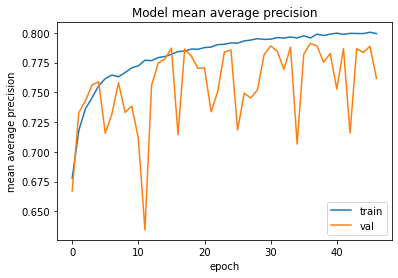

In [27]:
# Create line plot of mean average precision
import matplotlib.pyplot as plt
plt.plot(history.history['mean_average_precision_metric'])
plt.plot(history.history['val_mean_average_precision_metric'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

 7/27 [======>.......................] - ETA: 0s - loss: 0.1452 - mean_average_precision_metric: 0.7835

2022-08-14 01:55:26.902082: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1224510000 exceeds 10% of free system memory.


27/27 [==============================] - 1s 22ms/step - loss: 0.1516 - mean_average_precision_metric: 0.7589


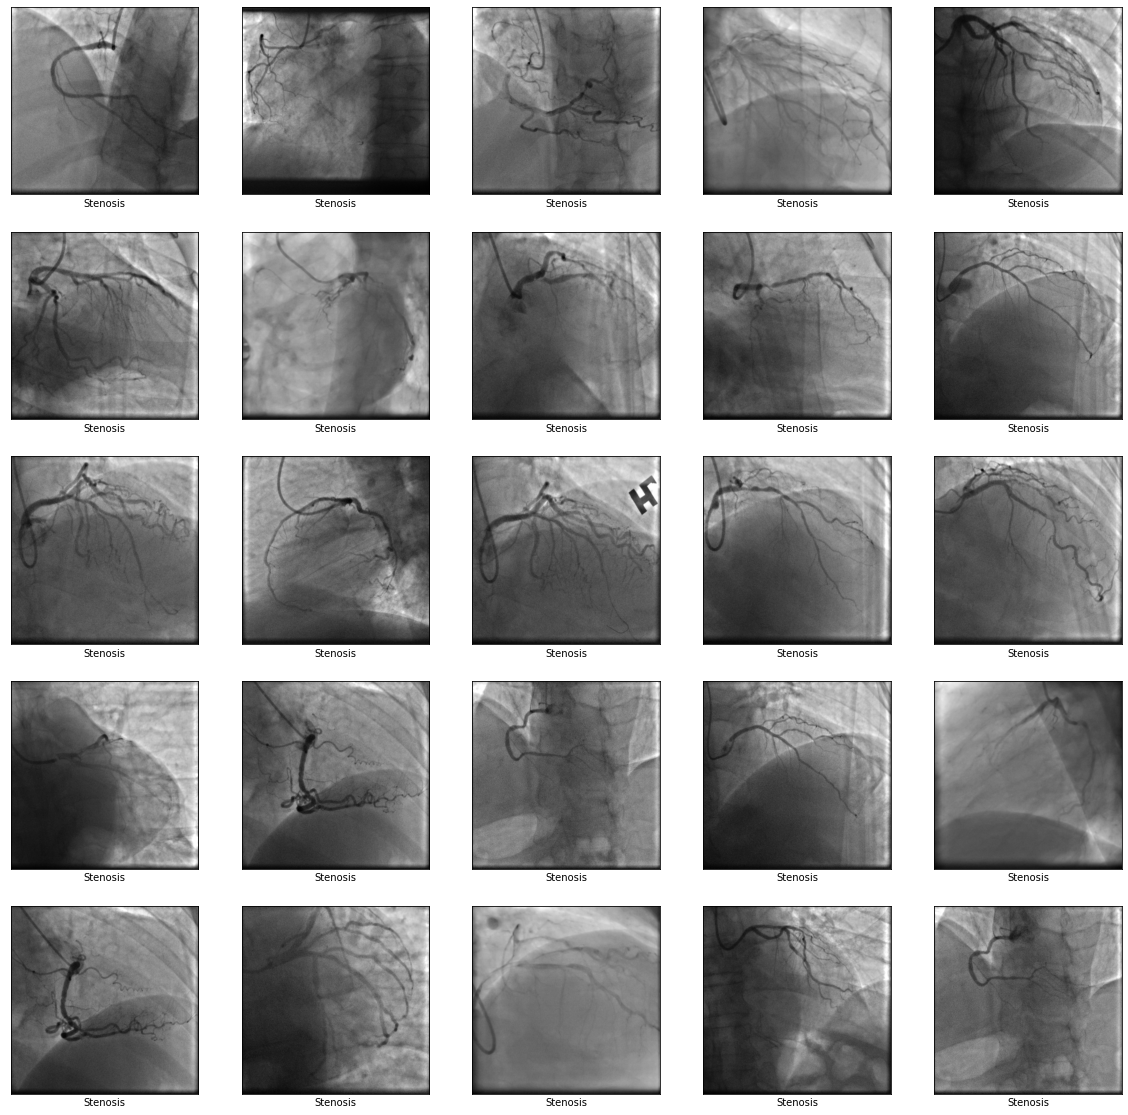

: 

In [28]:
# Visualize the model prediction images with bounding box dimensions predicted by the model and ground truth bounding box dimensions
# Create a figure with subplots of the images and bounding box dimensions
import matplotlib.pyplot as plt
model.evaluate(test_images, test_targets, verbose=1)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    plt.xlabel('Stenosis')
plt.show()



